# Borderlands 2 Weapon Rarity Prediction – First Draft

## Introduction

For Project 3, I wanted to focus on data from my favorite game of all time, Borderlands 2. The goal is to predict weapon rarity based on various attributes, such as manufacturer, damage type, and required content. Weapon rarity plays a significant role in the game's progression and overall gameplay experience. By predicting rarity based on these attributes, we can provide insights that could assist in understanding weapon distribution and balance. 

## What is Regression?
Regression is a statistical method used to find relationships between a dependent variable and independent variables. In my project, the dependent variable is weapon rarity, and the independent variables are attributes such as manufacturer, damage type, and required content.

Linear regression finds the best-fit line that minimizes errors between actual and predicted values. The formula is:
Y= β0 + β1X1 + β2X2 + ... + βnXn + ϵ

For my project, the variables in the equation relate to the following:
* Y is the predicted weapon rarity
* X1, X2, ... Xn are the independent variables (e.g., manufacturer, damage type, etc.).
* B0 is the intercept and Bn are the coefficients
* ϵ is the error term

# Experiment 1: Data Understanding
The dataset contains the following columns:

* Required Content: This one seems pretty relevant for predicting weapon rarity. Some weapons might be tied to specific content packs or downloadable content (DLCs), which could impact their rarity. I plan to keep this feature and see how it influences rarity prediction.

* Item Name: Since each item name is unique, it doesn’t really help in predicting weapon rarity. I’ll likely exclude this feature from the model.

* Flavor Text Perk: This one is mostly descriptive, but it could be useful for feature engineering later if it turns out to have any patterns connected to weapon rarity. I’ll keep an eye on it.

* Manufacturer: This is a categorical feature (e.g., Hyperion, Jakobs). It could be useful since some manufacturers might have rarer weapons in the game, so it might affect the rarity prediction. I’ll test it out.

* Damage Type: Another categorical feature (e.g., Fire, Corrosive). While it might not directly determine rarity, it could influence it depending on how weapons of different types are distributed in terms of rarity. This is worth exploring.

* Dropped By: This feature tells us where the weapon drops, but it might not be very useful for predicting rarity. I’ll evaluate it during the analysis phase to see if it’s worth keeping.

* Minimum Task Required: This could provide some valuable insight, especially since higher-difficulty tasks might drop rarer weapons. Depending on how it correlates with rarity, I might include it in the model.

* Location: Not sure if this will be a strong predictor for rarity, but it’s still worth checking if certain locations tend to have rarer weapons. I’ll investigate this to see if it’s useful.

* Rarity: This is the target variable, the one I’m trying to predict. It includes categories like Common, Rare, and Legendary, which are the different levels of rarity we’ll focus on.


In [33]:
import pandas as pd

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Define file path and sheet names
file_path = r"C:\Users\19857\Downloads\Borderlands 2 Loot Multi Pages 150520012018.xlsx"
sheet_names = ['Assault Rifles', 'Grenades', 'Pistols', 'Rocket Launchers', 'Shotguns', 'Sniper Rifles', 'SMGs']

weapon_dataframes = []

# Read each sheet with header row specified
for sheet_name in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
    
    # Keep only relevant columns for rarity prediction (EXCLUDING "Flavor Text Perk")
    selected_columns = [
        'Required Content', 'Manufacturer', 'Damage Type',
        'Dropped By', 'Minimum Task Required', 'Location', 'Rarity'
    ]
    
    # Drop 'Item Name' since it's unique per weapon and not useful for prediction
    df = df[selected_columns]
    
    weapon_dataframes.append(df)

# Concatenate all sheets into one DataFrame
combined_df = pd.concat(weapon_dataframes, ignore_index=True)

print("\nDataset Preview:")
print(combined_df.head())



Dataset Preview:
                   Required Content Manufacturer           Damage Type               Dropped By          Minimum Task Required              Location     Rarity
0                     Borderlands 2       Jakobs                   NaN                  McNally                       The Bane              The Dust  Legendary
1                     Borderlands 2       Torgue             Explosive               Midge-Mong                      Symbiosis  Southern Shelf - Bay  Legendary
2                     Borderlands 2       Bandit  Multi (Nonexplosive)                  Mad Dog              Breaking the Bank             Lynchwood  Legendary
3                     Borderlands 2       Torgue             Explosive             King of Orcs  Magic Slaughter: Badass Round    Murderlin's Temple  Legendary
4  Mr. Torgue's Campaign of Carnage       Vladof  Multi (Nonexplosive)  Hyperius the Invincible        Hyperius the Invincible    Washburne Refinery  Legendary


## Experiment 1: Data-Preprocessing: 
Handling Missing Values: We identified and removed any rows containing missing values.

Feature Selection: We selected features that are likely to influence the rarity of the weapon, including Manufacturer, Damage Type, and Required Content.

Feature Encoding: Since the features such as Manufacturer, Damage Type, and Rarity are categorical, we used Label Encoding to convert these into numerical values, which are necessary for machine learning models.

Data Splitting: We split the data into a training set and a testing set to evaluate the model's performance.

C:\Users\19857\AppData\Local\Temp\ipykernel_2144\2114392053.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='ffill')


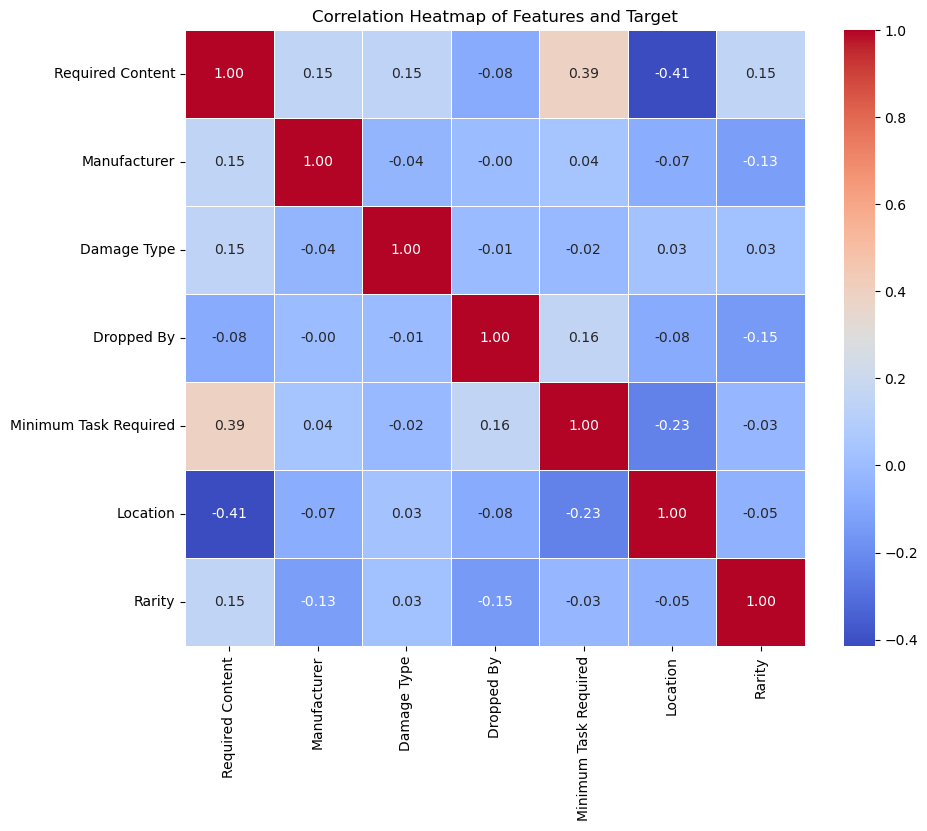


First few rows of the pre-processed data:
   Required Content  Manufacturer  Damage Type  Dropped By  Minimum Task Required  Location  Rarity
0                 0             3           10          44                     75        49       0
1                 0             6            2          46                     74        41       0
2                 0             0            4          40                     11        27       0
3                 0             6            2          33                     48        31       0
4                 5             7            4          28                     35        64       0

Missing values after pre-processing:
Required Content         0
Manufacturer             0
Damage Type              0
Dropped By               0
Minimum Task Required    0
Location                 0
Rarity                   0
dtype: int64

Unique values in 'Manufacturer' column after encoding:
[3 6 0 7 1 4 5 2]


In [37]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# File path and sheet names
file_path = r"C:\Users\19857\Downloads\Borderlands 2 Loot Multi Pages 150520012018.xlsx"
sheet_names = ['Assault Rifles', 'Grenades', 'Pistols', 'Rocket Launchers', 'Shotguns', 'Sniper Rifles', 'SMGs']

weapon_dataframes = []

# Read each sheet and select relevant columns
for sheet_name in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
    
    # Ensure 'Rarity' exists before processing
    if 'Rarity' not in df.columns:
        print(f"Warning: 'Rarity' column missing in {sheet_name}, skipping this sheet.")
        continue  
    
    selected_columns = ['Required Content', 'Manufacturer', 'Damage Type', 'Dropped By', 'Minimum Task Required', 'Location', 'Rarity']
    df = df[selected_columns]
    
    weapon_dataframes.append(df)

# Combine all sheets into one DataFrame
combined_df = pd.concat(weapon_dataframes, ignore_index=True)

# Drop rows where 'Rarity' is missing
combined_df = combined_df.dropna(subset=['Rarity'])

# Forward fill missing values for other columns
combined_df = combined_df.fillna(method='ffill')

# Encode categorical features
label_encoders = {}
features = ['Required Content', 'Manufacturer', 'Damage Type', 'Dropped By', 'Minimum Task Required', 'Location']
target = 'Rarity'

for col in features + [target]:  
    if combined_df[col].dtype == 'object':  
        label_encoder = LabelEncoder()
        combined_df[col] = label_encoder.fit_transform(combined_df[col])
        label_encoders[col] = label_encoder  

# Save preprocessed data
combined_df.to_csv('preprocessed_data.csv', index=False)
X = combined_df[features]
y = combined_df[target]

X.to_csv('X_features.csv', index=False)
y.to_csv('y_target.csv', index=False)

# Correlation matrix and heatmap
corr_matrix = combined_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features and Target")
plt.show()

# Display preview
print("\nFirst few rows of the pre-processed data:")
print(combined_df.head())
print("\nMissing values after pre-processing:")
print(combined_df.isnull().sum())
print("\nUnique values in 'Manufacturer' column after encoding:")
print(combined_df['Manufacturer'].unique())


## Experiment 1: Modeling
In this experiment, I’m creating a linear regression model using the features I’ve cleaned and selected. First, I’m converting the "Rarity" column into numeric values using LabelEncoder because it’s a categorical variable. After that, I’ll define the features (independent variables) and the target variable (dependent variable), which in this case is the "Rarity" that has now been encoded into numbers.

Next, I’ll split the data into training and testing sets (80-20 split). Then, I’ll set up the linear regression model, train it using the training data, and test it on the test data.

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

label_encoder_rarity = LabelEncoder()
combined_df['Rarity'] = label_encoder_rarity.fit_transform(combined_df['Rarity'])

X = combined_df[features]
y = combined_df['Rarity'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression(fit_intercept=True, copy_X=True, positive=False)
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

## Experiment 1: Evaluation
For this experiment, we need to evaluate how well our model is performing. A good way to do this is by calculating the Root Mean Squared Error (RMSE), which helps us understand how far off our predictions are from the actual values. RMSE is the square root of the Mean Squared Error (MSE), which we already have from our model output:

In [43]:
mse = mean_squared_error(y_test, y_pred_linear)
r_squared = r2_score(y_test, y_pred_linear)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r_squared}")

Mean Squared Error: 1.8685375751079552
R-squared: -0.10346707191414661


## Results and Analysis:

**Mean Squared Error (MSE):**

- The MSE is 1.8685, which shows how far off the model's predictions are from the actual values. It's not a super high value, but without a reference, it's hard to say if it's good or not. Ideally, we want to lower this number.

**R-Squared:**

- The R-squared value is -0.1034, which is pretty low and even negative. This means that the model is not explaining the data well at all. In fact, it's worse than just predicting the average value all the time.

**Conclusion:**
- The negative R-squared tells us that the model is not working well and is making poor predictions.

- The MSE isn’t huge, but since the R-squared is bad, we need to improve the model. It might need better features, a different approach, or more tuning

# Experiment 2: Random Forest Classification

### Objective: 
In experiment 2, I decided to move from a linear regression model since it did not work well with my dataset. The reason for this is that the variable "Rarity" is categorical rather than continuous which caused poor MSE and R-squared scores

### Changes:
- Swapped from Linear Regression to Random Forest Classifier (RFC)
- Changes from MSE and R-squared scores to classification accuracy and feature importance

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       1.00      1.00      1.00         2
           2       1.00      0.60      0.75         5
           3       0.76      0.93      0.84        14

    accuracy                           0.83        30
   macro avg       0.91      0.83      0.85        30
weighted avg       0.85      0.83      0.83        30



## Results and Analysis
 **Accuracy**:
- Achieved an **83.3% accuracy** on the test set, significantly better than linear regression.
  
 **Precision**:
- The model did great at predicting the right class, especially for classes 1 and 2.
  
 **Recall**:
- It performs well in identifying the rare classes, especially for class 1, but there is room for improvement in detecting class 2, as its recall is only 60%.
  
 **F1-Score**:
- The model has a balanced F1-score, especially for classes 0 and 3, indicating good performance in both precision and recall.

 **Conclusion:**
- Strengths: The Random Forest model demonstrated **strong performance** in handling the data and capturing different relationships between features.

- Weaknesses: The model showed **low recall (60%)** for class 2, indicating challenges in predicting this class effectively.

- Future Improvements: Possible solutions to improve recall for class 2 include **data balancing** or **further model tuning**.

# Experiment 3: Gradient Boosting Classification

### Objective: 
In this experiment, I decided to try Gradient Boosting Classifier (GBC) after using Random Forest in Experiment 2. I hoped GBC would improve performance since it's better at handling complex relationships in the data.

### Changes:
- Switched from Random Forest Classifier (RFC) to Gradient Boosting Classifier (GBC).
- Used GridSearchCV to tune hyperparameters like the number of trees, tree depth, and learning rate.

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

gb_model = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_gb = best_model.predict(X_test)

print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_gb)}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Gradient Boosting Accuracy: 0.8

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       1.00      1.00      1.00         2
           2       0.75      0.60      0.67         5
           3       0.75      0.86      0.80        14

    accuracy                           0.80        30
   macro avg       0.84      0.81      0.82        30
weighted avg       0.80      0.80      0.80        30



## Results and Analysis
 **Accuracy**:
- Achieved **80% accuracy** on the test set, which is slightly lower than the Random Forest model.
  
 **Precision**:
- The model performed well in precision, especially for class 1, where the precision is **1.00**. For class 2, the precision is **0.75**, indicating room for improvement.
  
 **Recall**:
- The recall for class 1 is **1.00**, meaning the model perfectly identifies all instances of class 1. However, class 2 still shows **lower recall (60%)**, suggesting that the model struggles to detect this class as well.
  
 **F1-Score**:
- The F1-score is balanced across most classes. Class 0 and 3 have good F1-scores **(around 0.80)**, but class 2 needs further attention with an F1-score of **0.67**.

 **Conclusion:**
- Strengths: Gradient Boosting performed well in terms of precision and recall for classes 1 and 3, with the model showing a **great ability** to identify rare cases.

- Weaknesses: The recall for class 2 is **still low**, indicating that the model struggles to predict this class effectively.

- Future Improvements: Try using **oversampling** for class 2, adjusting the **learning rate**, or adding **new features** to improve the model. Tuning **hyperparameters** could also help improve recall for certain classes.

# Impact Section  
This project helps analyze how weapon attributes influence rarity in *Borderlands 2*. It could be useful for game balancing by giving insights into how often certain rarities appear based on different factors. From a social perspective, it could help players understand loot mechanics better and potentially improve their gameplay strategies. However, a downside is that if developers or players rely too much on predictions, it might take away some of the randomness and excitement of the loot system, which is a key part of the game’s design.  

# Conclusion  
Through this project, I learned a lot about different machine learning models and how they perform on categorical data. Switching from Linear Regression to Random Forest was a huge improvement, and while Gradient Boosting performed well, it still had issues with class 2 recall. Tuning hyperparameters made a difference, but more work is needed to handle imbalanced data better. Overall, this project helped me understand model selection, feature importance, and the impact of different techniques on classification performance.  

# References  
- Borderlands 2 Weapon Data: [Google Sheets Dataset](https://docs.google.com/spreadsheets/d/1GemBl9OFuCSmA7w5o8h1ZbgVeDAn8Su9O2qoVABfO1s/edit?gid=536300451#gid=536300451)  